# Compute `SEDFRAC`

`SEDFRAC` is the fraction of each grid cell at each detpth that contains subgrid-scale bottom sediment.

This procedure has the following steps.
1. Compute mapping weights for `etopo_grid` to `ocean_grid` using ESMF `conservative` scheme.
1. At each cell in `ocean_grid`, find all contributing `etopo_grid` cells; bin the data on the model vertical grid and sum the weights at each depth.
1. Normalize the resulting matrix by dividing by the sum of the weights over depth.
1. Write netCDF file for computation of [Fe sediment flux on subgrid-scale bathymetry](Fe_sediment_flux_forcing.ipynb).


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tqdm

import numpy as np
import xarray as xr
import scipy.sparse as sps

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import esmlab
import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Get grid and mapping files

Here we are assuming that several grid files and a conservative mapping file between them exists.

- `_ensure_grid_files.ipynb` generates the ETOPO1 SCRIP grid file;
- `esmf_gen_weights_etopo1_to_POP.pbs` uses an MPI implementation of `ESMF_RegridWeightGen` to compute mapping files.

In [3]:
dst_grid = 'POP_tx0.1v3'

In [4]:
# Parameters
dst_grid = "POP_gx3v7"


In [5]:
src_grid = 'etopo1'

file_src_grid = util.file_name_grid(src_grid)
file_dst_grid = util.file_name_grid(dst_grid)
file_weights = util.file_name_weight(src_grid, dst_grid, 'conservative')

src = xr.open_dataset(file_src_grid)
dst = xr.open_dataset(file_dst_grid)
mf = xr.open_dataset(file_weights)

In [6]:
dims_dst = tuple(dst.grid_dims.values[::-1])
dims_src = tuple(src.grid_dims.values[::-1])

n_dst = np.prod(dims_dst)
n_src = np.prod(dims_src)

Convert mapping file to sparse matrix.

In [7]:
%%time
row = mf.row.values - 1
col = mf.col.values - 1
S = mf.S.values
A = sps.csr_matrix((S, (row, col)), shape=[n_dst, n_src])

CPU times: user 1.59 s, sys: 2.85 s, total: 4.44 s
Wall time: 5.38 s


## Read topographic data

Read the data, set the `data_src`, mask out positive values (land) and make positive-down. Make a quick plot.

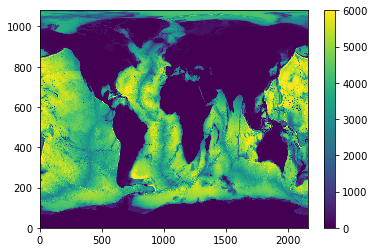

In [8]:
file_src_data = util.file_name_topo('etopo1')

with xr.open_dataset(file_src_data) as ds:
    data_src = ds.z.values
    
data_src = np.where(data_src > 0., 0., -1.0 * data_src)
plt.pcolormesh(data_src[::10, ::10], vmin=0, vmax=6000.)
plt.colorbar()

Sanity check: Remap `data_src` to destination grid. Does this look like the field above?  It should.

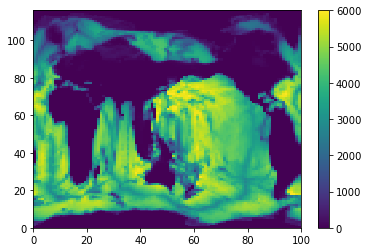

In [9]:
data_src_flat = data_src.reshape(-1, n_src)

data_dst_flat = A.dot(data_src_flat.T).T

data_dst = data_dst_flat.reshape(dims_dst)
plt.pcolormesh(data_dst, vmin=0, vmax=6000.)
plt.colorbar()

## Make the model vertical coordinate into a depth bins array

In [10]:
ds_dst_grid = pop_tools.get_grid(dst_grid)

i_pacific = util.nlon_pacific_xsection[dst_grid]

zbins_e = np.concatenate((ds_dst_grid.z_w.values, [ds_dst_grid.z_w_bot.values[-1]]))
zbins_e = zbins_e * 1e-2
z_t = ds_dst_grid.z_t.values * 1e-2
zbins_e

array([   0.      ,   10.      ,   20.      ,   30.      ,   40.      ,
         50.      ,   60.      ,   70.      ,   80.      ,   90.      ,
        100.      ,  110.      ,  120.      ,  130.      ,  140.      ,
        150.      ,  160.      ,  170.196808,  180.761292,  191.821243,
        203.499313,  215.923446,  229.233124,  243.584534,  259.155793,
        276.152589,  294.814713,  315.423736,  338.312257,  363.874728,
        392.580478,  424.98885 ,  461.766575,  503.706883,  551.749119,
        606.996663,  670.728582,  744.39803 ,  829.606956,  928.043538,
       1041.368196, 1171.040188, 1318.093626, 1482.900716, 1664.992064,
       1863.014408, 2074.873978, 2298.039076, 2529.904017, 2768.098509,
       3010.670677, 3256.13847 , 3503.448607, 3751.891888, 4001.011634,
       4250.524544, 4500.260482, 4750.120091, 5000.046829, 5250.00927 ,
       5499.990364])

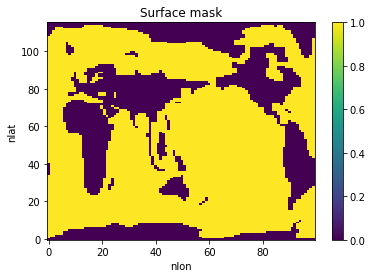

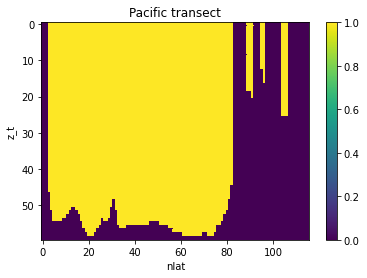

In [11]:
MASK = util.get_3d_ocean_mask(dst_grid)

plt.figure()
MASK.isel(z_t=0).plot()
h = plt.title('Surface mask')

plt.figure()
MASK.isel(nlon=i_pacific).plot(yincrease=False)
h = plt.title('Pacific transect')

Read the model topography file

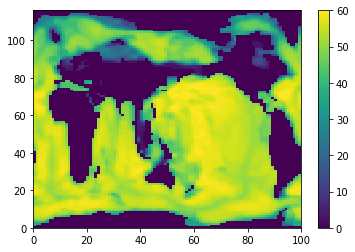

In [12]:
topo_file = util.file_name_pop_topography(dst_grid)
kmt_flat = np.fromfile(topo_file, dtype='>i4', count=-1)
kmt = kmt_flat.reshape(dims_dst)

assert kmt_flat.shape[0] == np.prod(dims_dst)
assert kmt_flat.max() <= len(z_t)
assert (kmt == ds_dst_grid.KMT.values).all()

plt.pcolormesh(kmt)
plt.colorbar()

## Compute `sedfrac`

Find the points that map to each cell in the destination grid. Sum the weights from these points. 

In [13]:
%%time
data_src_flat_sq = np.squeeze(data_src_flat)

nk = len(zbins_e)-1

# sum of weights at each depth level
wsum_dst_flat = np.zeros((nk, n_dst)) 

# the data from source grid mapped to each depth level
data_dst_flat = np.zeros((nk, n_dst)) 

def map_point_i(i):
    
    # local slices of weights and data
    wsum_dst_flat_i = np.zeros((nk)) 
    data_dst_flat_i = np.zeros((nk)) 

    # find the points in the source grid that map to point i   
    # mapped_points = column indices of mapped points
    # w = the weights for each mapped point
    _, mapped_points, w = sps.find(A.getrow(i))

    # get the data from the source grid
    mapped_data = data_src_flat_sq[mapped_points].copy()

    # mask out where data are not in range
    mapped_data[mapped_data <= 0] = -1
    if all(mapped_data == -1) or kmt_flat[i] == 0: 
        return wsum_dst_flat_i, data_dst_flat_i

    # truncate the depth bins according to KMT (the index of the deepest cell)
    zbins_e_i = zbins_e[:kmt_flat[i]+1].copy()
    zmax_i = zbins_e_i[-1].copy()
    zbins_e_i[-1] = 1e30 # set to a large value such that depth below the max depth model map to the bottom
    
    # bin the data in depth
    ind_zbin = np.searchsorted(zbins_e_i, mapped_data, side='left')

    # replace the topo data larger than zmax_i with zmax_i
    mapped_data = np.where(mapped_data > zmax_i, zmax_i, mapped_data)

    # loop over mapped points and sum weights at each k-level
    for n in range(mapped_data.size):
        k = ind_zbin[n] - 1
        if k < 0: continue
        wsum_dst_flat_i[k] += w[n]
        data_dst_flat_i[k] += w[n] * mapped_data[n]
        
    return wsum_dst_flat_i, data_dst_flat_i

# loop over points in destination grid
result = []
for i in range(n_dst):
    result.append(map_point_i(i))

CPU times: user 4min 2s, sys: 1.24 s, total: 4min 3s
Wall time: 4min 3s


In [14]:
for i, (wsum, data) in enumerate(result):
    wsum_dst_flat[:, i] = wsum
    data_dst_flat[:, i] = data
    
data_dst_flat = data_dst_flat / np.where(wsum_dst_flat==0., np.nan, wsum_dst_flat)
    
wtot_dst_flat = wsum_dst_flat.sum(axis=0)
wtot_dst_flat = np.where(wtot_dst_flat==0., np.nan, wtot_dst_flat)
wsum_dst_flat = wsum_dst_flat / wtot_dst_flat
wsum_dst_flat = np.where(np.isnan(wsum_dst_flat), 0., wsum_dst_flat)

dso = xr.Dataset()
dso['sedfrac'] = xr.DataArray(
    wsum_dst_flat.reshape((nk,)+dims_dst), 
    dims=('z_t', 'nlat', 'nlon')
)

dso['sum_of_weights'] = xr.DataArray(
    wtot_dst_flat.reshape(dims_dst),
    dims=('nlat', 'nlon')
)

dso['remapped_topography'] = xr.DataArray(
    data_dst_flat.reshape((nk,)+dims_dst),
    dims=('z_t', 'nlat', 'nlon')
)

dso['z_t'] = xr.DataArray(z_t * 1e2, dims=('z_t'))
dso.z_t.encoding['_FillValue'] = None
dso

<xarray.Dataset>
Dimensions:              (nlat: 116, nlon: 100, z_t: 60)
Coordinates:
  * z_t                  (z_t) float64 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    sedfrac              (z_t, nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sum_of_weights       (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    remapped_topography  (z_t, nlat, nlon) float64 nan nan nan ... nan nan nan

Make some plots of the `sedfrac` field; this should sum to 1 in the column where there is ocean. 

There are a few points missing on the hi-res grid where `sedfrac.sum('z_t')` is zero. This could be fixed...but isn't a big deal, especially since we're filling land-adjacent points below.

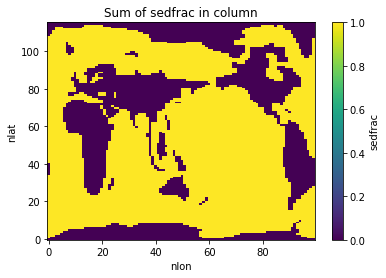

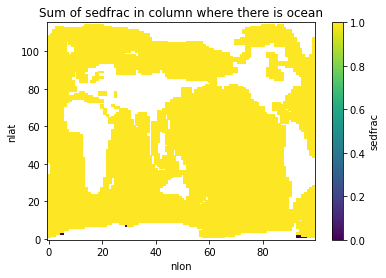

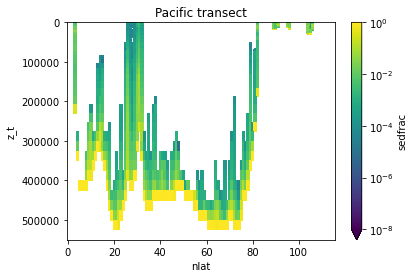

In [15]:
dso.sedfrac.sum('z_t').plot()
h = plt.title('Sum of sedfrac in column')

plt.figure()
dso.sedfrac.sum('z_t').where(ds_dst_grid.KMT > 0).plot()
h = plt.title('Sum of sedfrac in column where there is ocean')

plt.figure()
dso.sedfrac.isel(nlon=i_pacific).plot(yincrease=False, norm=colors.LogNorm(vmin=1e-8, vmax=1.))
h = plt.title('Pacific transect')

There should be no `sedfrac` outside the model domain, so the vertical sum of the masked `sedfrac` array should be equal to the sum of the unmasked array.

In [16]:
assert (dso.sedfrac.where(MASK).sum('z_t') == dso.sedfrac.sum('z_t')).all()

`sedfrac` should sum to `one` in the column, except where there are unmapped points.

In [17]:
# get the sedfrac where there is ocean
test_arr = dso.where(MASK).sedfrac.sum('z_t')

# there are some-points where sedfrac was not mapped
# set these to zero
test_arr = xr.where(test_arr == 0, 1., test_arr)

# perform test
np.testing.assert_allclose(test_arr, 1.)

`sedfrac` should not be greater than one or less than zero.

In [18]:
assert (dso.sedfrac <= 1.).all()
assert (dso.sedfrac >= 0).all()

No remapped topography should fall outside the right `z` level

In [19]:
for k in range(nk):
    data_at_k = dso.remapped_topography[k, :, :].values.reshape(-1)
    data_at_k = data_at_k[~np.isnan(data_at_k)]

    assert (data_at_k <= zbins_e[k+1]+1e-7).all()
    assert (zbins_e[k]-1e-7 < data_at_k).all()

In [20]:
print(f'writing {util.sedfrac_file(dst_grid)}')
dso.to_netcdf(util.sedfrac_file(dst_grid))

writing /glade/work/mclong/cesm_inputdata/work/sedfrac.POP_gx3v7.nc
